In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# general packages
import numpy as np # linear algebra
import pandas as pd # data processing, 
import zipfile
import re

# packages for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# nlp packages
import nltk
#nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
#nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [2]:
# get list of the word2vec models
list_w2v= list(api.info()['models'].keys())
print(list_w2v)

#save the google news 300 model
google_news= api.load('word2vec-google-news-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
[=====================================-------------] 74.9% 1245.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
NotebookApp.rate_limit_window=1.0 (secs)



[===========================================-------] 86.2% 1433.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
NotebookApp.rate_limit_window=1.0 (secs)



[===============================================---] 95.5% 1588.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
NotebookApp.rate_limit_window=1.0 (secs)



In [3]:
# get the package versions

print('numpy package version is:{}'.format(np.__version__))
print('pandas package version is:{}'.format(pd.__version__))
print('matplotlib package version is:{}'.format(matplotlib.__version__))
print('seaborn package version is:{}'.format(sns.__version__))
print('scikit-learn package version is:{}'.format(sklearn.__version__))
print('nltk package version is:{}'.format(nltk.__version__))
print('re package version is:{}'.format(re.__version__))
print('gensim package version is:{}'.format(gensim.__version__))

numpy package version is:1.26.4
pandas package version is:2.2.3
matplotlib package version is:3.7.2
seaborn package version is:0.12.2
scikit-learn package version is:1.2.2
nltk package version is:3.9.1
re package version is:2.2.1
gensim package version is:4.3.3


In [4]:
# extract the training data
zip_train= "/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip"

with zipfile.ZipFile(zip_train, 'r') as zip1:
    zip1.extractall('/kaggle/working')

# extract the test data
zip_test= '/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip'

with zipfile.ZipFile(zip_test, 'r') as zip2:
    zip2.extractall('kaggle/working')



In [5]:
# load training data into dataframe
train_df= pd.read_csv("/kaggle/working/labeledTrainData.tsv", sep= '\t')

# load test data into dataframe
test_df= pd.read_csv('/kaggle/working/kaggle/working/testData.tsv', sep= '\t')

In [6]:
# look at training dataframe
train_df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [7]:
# look at test dataframe
test_df.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


<Axes: title={'center': 'Training Data Labels'}, xlabel='sentiment', ylabel='count'>

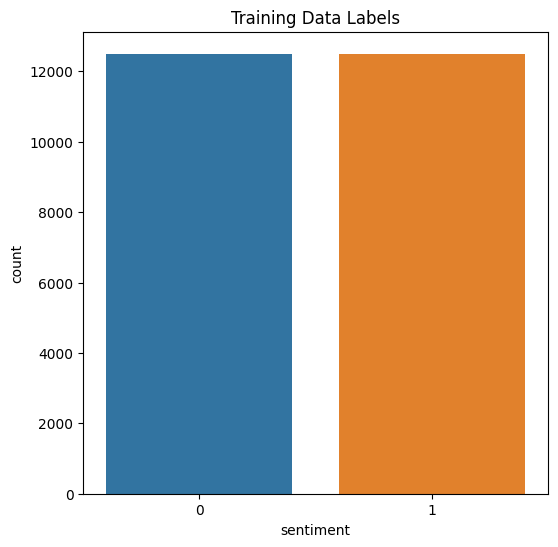

In [8]:
# check to see if training data is balanced
fig1= plt.figure(figsize= (6, 6))
ax1= plt.gca()
ax1.set_title('Training Data Labels')
ax1.set_ylabel('Counts')
ax1.set_xlabel('Label')
sns.countplot(x= train_df['sentiment'])

Training dataset is balanced.

In [9]:
# make function to clean text

stoplist= list(stopwords.words('english'))

def clean_text(review1):
    # make text lowercase
    rev1= review1.lower()
    # remove hyperlinks
    rev1= re.sub(r'https?://\S+', "", rev1)
    # remove non alphabet characters
    rev1= re.sub(r'[^a-z ]', "", rev1)
    # make tokens
    rev1= word_tokenize(rev1)
    return rev1
    

In [10]:
# define lemmatizer
lemmatizer= WordNetLemmatizer()

# make function to lemmatize text and remove stopwords
def lemma_text(text1):
    pos1= pos_tag(text1)
    # take first character from pos_tag for each token
    char1= [word1[1][0] for word1 in pos1]
    # dictionary for pos
    pos_dict= {'J':wordnet.ADJ, 'R':wordnet.ADV, 'V':wordnet.VERB, 'N':wordnet.NOUN} 
    good_list= [pos_dict.get(word1, wordnet.NOUN) for word1 in char1]
    #lemmatize using token and pos_tag
    lemma_list= [lemmatizer.lemmatize(x1, y1) for x1, y1 in zip(text1,good_list)]
    #remove stopwords
    no_stop_list= [word1 for word1 in lemma_list if word1 not in stoplist]
    return no_stop_list


In [11]:
# test functions
string10= "The dog was running quickly in the park after it rained the night before.  the dog jumped at the park yesterday."

string11= clean_text(string10)

string12= lemma_text(string11)

print(string10)
print('-'*80)
print(string11)
print('-'*80)
print(string12)

The dog was running quickly in the park after it rained the night before.  the dog jumped at the park yesterday.
--------------------------------------------------------------------------------
['the', 'dog', 'was', 'running', 'quickly', 'in', 'the', 'park', 'after', 'it', 'rained', 'the', 'night', 'before', 'the', 'dog', 'jumped', 'at', 'the', 'park', 'yesterday']
--------------------------------------------------------------------------------
['dog', 'run', 'quickly', 'park', 'rain', 'night', 'dog', 'jump', 'park', 'yesterday']


In [12]:
# split the training data into training and validation

x_train, x_val, y_train, y_val= train_test_split(train_df['review'], train_df['sentiment'], test_size= 0.2, shuffle= True, random_state= 24)

# check the sizes of new series
print('size of x_train is:{}'.format(x_train.shape))
print('size of x_val is:{}'.format(x_val.shape))
print('size of y_train is:{}'.format(y_train.shape))
print('size of y_val is:{}'.format(y_val.shape))

size of x_train is:(20000,)
size of x_val is:(5000,)
size of y_train is:(20000,)
size of y_val is:(5000,)


In [13]:
# apply clean_text and lemma_text to training, val and test
train_clean= x_train.apply(clean_text)
val_clean= x_val.apply(clean_text)
test_clean= test_df['review'].apply(clean_text)

train_lemma= train_clean.apply(lemma_text)
val_lemma= val_clean.apply(lemma_text)
test_lemma= test_clean.apply(lemma_text)

In [14]:
# make the word2vec model
#sg= 0 cbow
vsize= 200
cbow1= Word2Vec(train_lemma, window= 5, min_count= 2, vector_size= vsize, sg= 0)

In [15]:
# function to make sentence embedding (average of word embeddings)
# word2vec model with cbow
def avg_sent_text_cbow(text1):
    vec1= np.zeros(vsize)
    count1= 0
    for word1 in text1:
        if word1 in cbow1.wv:
            vec1= vec1 + cbow1.wv[word1]
            count1= count1 + 1
    if count1 == 0:
        count1= 1
    vec1= vec1/count1
    return vec1

In [16]:
# apply the avg_sent_text function to the training, val and test lemmatized datasets
# cbow model
train_avg_sent_cbow= train_lemma.apply(avg_sent_text_cbow)
val_avg_sent_cbow= val_lemma.apply(avg_sent_text_cbow)
test_avg_sent_cbow= test_lemma.apply(avg_sent_text_cbow)

train_final_cbow= train_avg_sent_cbow.tolist()
val_final_cbow= val_avg_sent_cbow.tolist()
test_final_cbow= test_avg_sent_cbow.tolist()

In [17]:
# train and test the random forest classifier with word2vec cbow model
forest_cbow= RandomForestClassifier()

# train model
forest_cbow.fit(train_final_cbow, y_train)

# predict with training data
forest_cbow_pred_train= forest_cbow.predict_proba(train_final_cbow)
forest_cbow_pred_train= forest_cbow_pred_train[:, 1]                     # select the class 1 probabilities
# predict with validation
forest_cbow_pred_val= forest_cbow.predict_proba(val_final_cbow)
forest_cbow_pred_val= forest_cbow_pred_val[:, 1]                        # select the class 1 probabilities

# evaluate using area under roc curve
print('Area under the ROC for word2vec cbow training is:{}'.format(roc_auc_score(y_train, forest_cbow_pred_train)))
print('Area under the ROC for word2vec cbow validation is:{}'.format(roc_auc_score(y_val, forest_cbow_pred_val)))

train_cbow_area_roc= roc_auc_score(y_train, forest_cbow_pred_train)
val_cbow_area_roc= roc_auc_score(y_val, forest_cbow_pred_val)

dict1= {'cbow':{'Train_area_ROC': train_cbow_area_roc, 'Val_area_ROC': val_cbow_area_roc}}

compare_df= pd.DataFrame.from_dict(dict1, orient= 'columns')
print(compare_df)

Area under the ROC for word2vec cbow training is:1.0
Area under the ROC for word2vec cbow validation is:0.8900986346100184
                    cbow
Train_area_ROC  1.000000
Val_area_ROC    0.890099


In [18]:
# make the word2vec model
#sg= 1 skipgrams
vsize= 200
skip1= Word2Vec(train_lemma, window= 5, min_count= 2, vector_size= vsize, sg= 1)

In [19]:
# function to make sentence embedding (average of word embeddings)
# word2vec model with sg= 1 skipgrams
def avg_sent_text_sg(text1):
    vec1= np.zeros(vsize)
    count1= 0
    for word1 in text1:
        if word1 in skip1.wv:
            vec1= vec1 + skip1.wv[word1]
            count1= count1 + 1
    if count1 == 0:
        count1= 1
    vec1= vec1/count1
    return vec1

In [20]:
# apply the avg_sent_text function to the training, val and test lemmatized datasets
# skipgrams word2vec model

train_avg_sent_sg= train_lemma.apply(avg_sent_text_sg)
val_avg_sent_sg= val_lemma.apply(avg_sent_text_sg)
test_avg_sent_sg= test_lemma.apply(avg_sent_text_sg)

train_final_sg= train_avg_sent_sg.tolist()
val_final_sg= val_avg_sent_sg.tolist()
test_final_sg= test_avg_sent_sg.tolist()

In [21]:
# train and test the random forest classifier with word2vec skipgrams model
forest_sg= RandomForestClassifier()

# train model
forest_sg.fit(train_final_sg, y_train)

# predict with training data
forest_sg_pred_train= forest_sg.predict_proba(train_final_sg)
forest_sg_pred_train= forest_sg_pred_train[:, 1]                     # select the class 1 probabilities
# predict with validation
forest_sg_pred_val= forest_sg.predict_proba(val_final_sg)
forest_sg_pred_val= forest_sg_pred_val[:, 1]                        # select the class 1 probabilities

# evaluate using area under roc curve
print('Area under the ROC for word2vec skipgrams training is:{}'.format(roc_auc_score(y_train, forest_sg_pred_train)))
print('Area under the ROC for word2vec skipgrams validation is:{}'.format(roc_auc_score(y_val, forest_sg_pred_val)))

train_sg_area_roc= roc_auc_score(y_train, forest_sg_pred_train)
val_sg_area_roc= roc_auc_score(y_val, forest_sg_pred_val)

dict2= {'skipgrams':{'Train_area_ROC': train_sg_area_roc, 'Val_area_ROC': val_sg_area_roc}}
df2= pd.DataFrame.from_dict(data= dict2, orient= 'columns')


compare_df= pd.concat([compare_df, df2], axis= 1)
print(compare_df)


Area under the ROC for word2vec skipgrams training is:1.0
Area under the ROC for word2vec skipgrams validation is:0.9068748863988367
                    cbow  skipgrams
Train_area_ROC  1.000000   1.000000
Val_area_ROC    0.890099   0.906875


In [22]:
# function to make sentence embedding (average of word embeddings)
# pretrained word2vec model: google news 300
def avg_sent_text_google(text1):
    vec1= np.zeros(google_news.vector_size)
    count1= 0
    for word1 in text1:
        if word1 in google_news.key_to_index:
            vec1= vec1 + google_news[word1]
            count1= count1 + 1
    if count1 == 0:
        count1= 1
    vec1= vec1/count1
    return vec1

In [23]:
# apply the avg_sent_text function to the training, val and test lemmatized datasets
# pretrained word2vec model google news 300

train_avg_sent_google= train_lemma.apply(avg_sent_text_google)
val_avg_sent_google= val_lemma.apply(avg_sent_text_google)
test_avg_sent_google= test_lemma.apply(avg_sent_text_google)

train_final_google= train_avg_sent_google.tolist()
val_final_google= val_avg_sent_google.tolist()
test_final_google= test_avg_sent_google.tolist()

In [24]:
# train and test the random forest classifier with word2vec pretrained model: google news 300
forest_google= RandomForestClassifier()

# train model
forest_google.fit(train_final_google, y_train)

# predict with training data
forest_google_pred_train= forest_google.predict_proba(train_final_google)
forest_google_pred_train= forest_google_pred_train[:, 1]                     # select the class 1 probabilities
# predict with validation
forest_google_pred_val= forest_google.predict_proba(val_final_google)
forest_google_pred_val= forest_google_pred_val[:, 1]                        # select the class 1 probabilities

# evaluate using area under roc curve
print('Area under the ROC for word2vec pretrained google news 300 training is:{}'.format(roc_auc_score(y_train, forest_google_pred_train)))
print('Area under the ROC for word2vec pretrained google news 300 validation is:{}'.format(roc_auc_score(y_val, forest_google_pred_val)))

train_google_area_roc= roc_auc_score(y_train, forest_google_pred_train)
val_google_area_roc= roc_auc_score(y_val, forest_google_pred_val)

dict3= {'google_news':{'Train_area_ROC': train_google_area_roc, 'Val_area_ROC': val_google_area_roc}}
df3= pd.DataFrame.from_dict(dict3, orient= 'columns')


compare_df= pd.concat([compare_df, df3], axis= 1)
print(compare_df)


Area under the ROC for word2vec pretrained google news 300 training is:1.0
Area under the ROC for word2vec pretrained google news 300 validation is:0.8811447829225771
                    cbow  skipgrams  google_news
Train_area_ROC  1.000000   1.000000     1.000000
Val_area_ROC    0.890099   0.906875     0.881145


3 word2vec models were trained and tested.  The metric for this dataset was area under the ROC curve.  The best performing model was the word2vec model trained on the training data using skipgrams.